In [2]:

# Dataset de 23.6 MB
import gdown
import os

file_id = '1yY7QtyB3UP8ToKZ0CUDFrDXCZRmdJnll'
dataset_url = f'https://drive.google.com/uc?id={file_id}'
dataset_path = 'data/Loan_default.csv'

os.makedirs(os.path.dirname(dataset_path), exist_ok=True)

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    gdown.download(dataset_url, dataset_path, quiet=False)
    print("Dataset downloaded and saved to", dataset_path)
else:
    print("Dataset already exists")


Dataset already exists


# 1. Listado de variables y selección

1- **LoanID** es un identificador único del préstamo y no se utilizará en el análisis (es sólo un identificador, no aporta información para predecir un incumplimiento del préstamo).

2- **Age** representa la edad de la persona que quiere obtener el préstamo, en años y se utilizará como variable de entrada. Podría influir en la probabilidad de incumplimiento (menor edad, más chances de que ante un incumplimiento se logre cobrar igual el préstamo y mayor edad, más chances de que la persona se transforme en moroso incobrable).

3- **Income** es el ingreso anual del de la persona que quiere obtener el préstamo y se utilizará como variable de entrada, porque es un factor importante para evaluar la capacidad de pago.

4- **LoanAmount** monto total del préstamo y se utilizará como variable de entrada. Es una variable muy importante en el análisis de predicción de incumplimiento (refleja la cantidad de dinero en la cual la persona se endeuda).

5- **CreditScore** es el puntaje de crédito de la persona y se utilizará como variable de entrada porque es un indicador clave del comportamiento financiero pasado y de la probabilidad de incumplimiento.

6- **MonthsEmployed** indica los meses que la persona ha estado empleado y se utilizará como variable de entrada, ya que la estabilidad laboral puede ser un factor determinante en la capacidad de pago del préstamo y también la capacidad de ahorro.

7- **NumCreditLines** es el número de líneas de crédito abiertas y se utilizará como variable de entrada porque indica la experiencia y el manejo del crédito por parte de la persona, por otra parte, también ayuda a saber el nivel de endeudamiento actual y si podrá ser capaz de afrontar todas las deudas.

8- **InterestRate** es la tasa de interés del préstamo y se utilizará como variable de entrada, ya que una tasa alta podría aumentar el riesgo de incumplimiento y también influye sobre el capital total a devolver.

9- **LoanTerm** es la duración del préstamo en meses y se utilizará como variable de entrada, ya que un plazo más largo puede reducir el monto de los pagos mensuales, lo cual facilita el cumplimiento de las cuotas del préstamo (menor monto). Sin embargo, también puede aumentar el costo total del préstamo debido a los intereses acumulados.

10- **DTIRatio** es la relación deuda-ingreso de la persona y se utilizará como variable de entrada, ya que es un indicador directo de la carga de deuda respecto a sus ingresos.

11- **Education** describe el nivel educativo de la persona y se utilizará como variable de entrada, ya que puede influir en las oportunidades de empleo y la estabilidad financiera.

12- **EmploymentType** indica el tipo de empleo de la persona, como a tiempo completo o parcial, y se utilizará como variable de entrada porque puede afectar la estabilidad del ingreso de la persona.

13- **MaritalStatus** es el estado civil de la persona y se utilizará como variable de entrada, ya que puede influir en la situación financiera y las responsabilidades económicas.

14- **HasMortgage** señala si la persona tiene una hipoteca y se utilizará como variable de entrada, porque tener una hipoteca (que es una deuda existente), puede afectar la capacidad de asumir más deuda.

15- **HasDependents** indica si la persona tiene personas a cargo y se utilizará como variable de entrada, ya que tener otras personas a cargo puede aumentar las obligaciones financieras.

16- **LoanPurpose** describe el propósito del préstamo y se utilizará como variable de entrada porque podría influir en el riesgo asociado al mismo.

17- **HasCoSigner** muestra si el préstamo tiene un garante y se utilizará como variable de entrada. Un garante puede reducir el riesgo de incumplimiento al compartir la responsabilidad del préstamo.

18- **Default** indica si la persona incumplió el préstamo y se utilizará como variable de salida. Es la variable objetivo que se busca predecir, con posibles valores de 0 (no incumplido) y 1 (incumplido).

# 2. Análisis detallado de un conjunto de variables

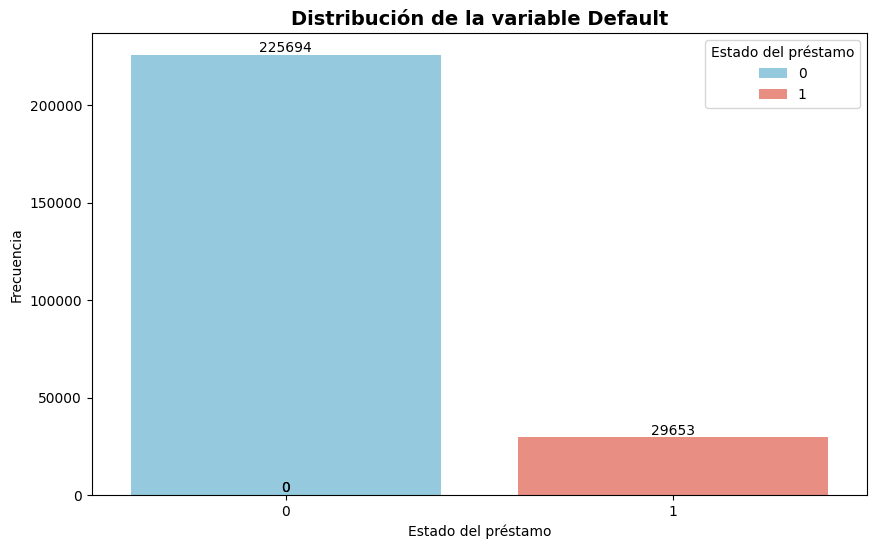

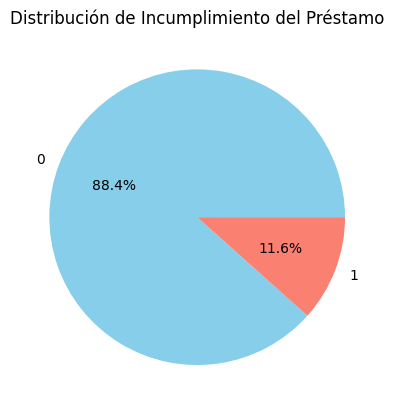

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(dataset_path)
default_counts = df['Default'].value_counts()

data = pd.DataFrame({
    'Estado del préstamo': default_counts.index,
    'Frecuencia': default_counts.values
})

color_palette = {0: 'skyblue', 1: 'salmon'}
plt.figure(figsize=(10, 6))

ax = sns.barplot(x='Estado del préstamo', y='Frecuencia', data=data, palette=color_palette, hue='Estado del préstamo', errorbar=None)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Distribución de la variable Default', fontsize=14, weight='bold')
plt.show()

# Gráfico de pastel
default_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Distribución de Incumplimiento del Préstamo')
plt.ylabel('')
plt.show()

# Distribucion variables de entrada
**Age:** 
Transformacion: Si, normalizar.
Cantidad de nulos:

In [4]:
nullosAge = df['Age'].isnull().sum()
print(nullosAge)

0


**Distribucion Age:**
Minimo en 18 años y maximo en 69 años.

<Axes: >

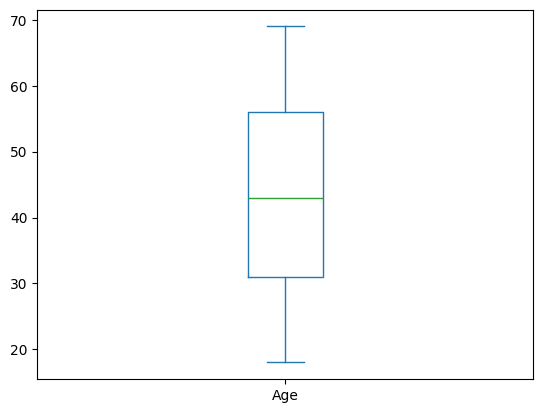

In [5]:
df['Age'].plot.box()

In [30]:
df['Age'].max()

np.int64(69)

In [31]:
df['Age'].min()

np.int64(18)

**Relacion con variable de salida?**

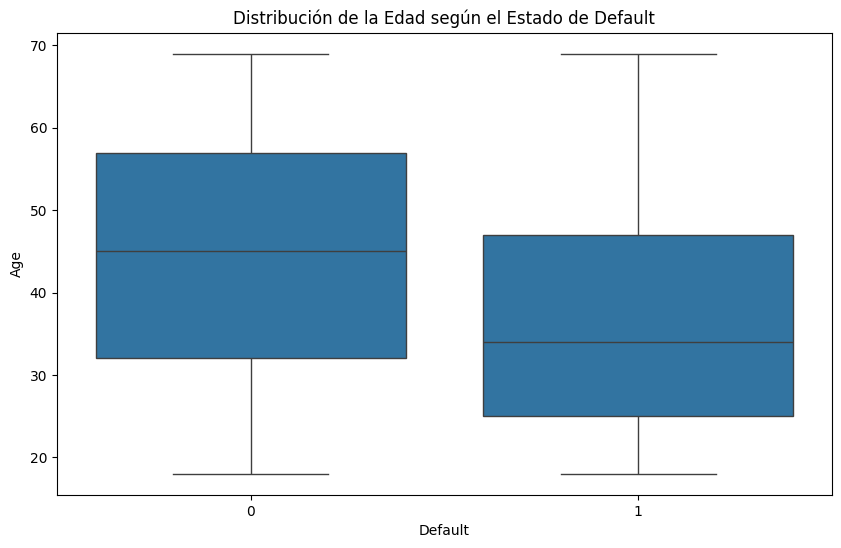

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Default', y='Age', data=df)
plt.title('Distribución de la Edad según el Estado de Default')
plt.show()

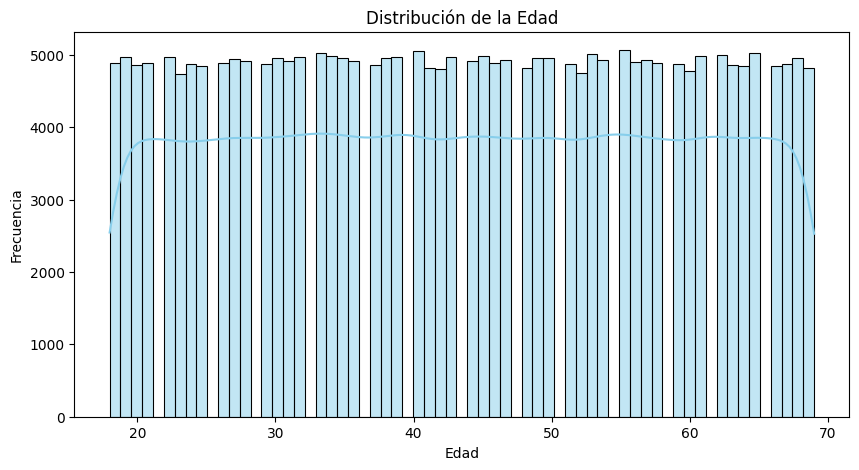

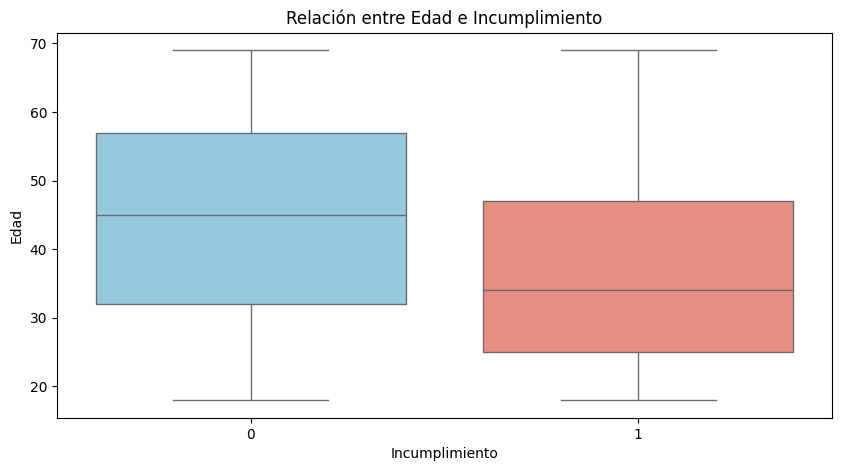

In [30]:
# Histograma de la variable 'Age'
plt.figure(figsize=(10, 5))
sns.histplot(df['Age'], kde=True, color='skyblue')
plt.title('Distribución de la Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de 'Age' vs 'Default'
plt.figure(figsize=(10, 5))
sns.boxplot(x='Default', y='Age', hue='Default', data=df, palette=['skyblue', 'salmon'], legend=False)
plt.title('Relación entre Edad e Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Edad')
plt.show()

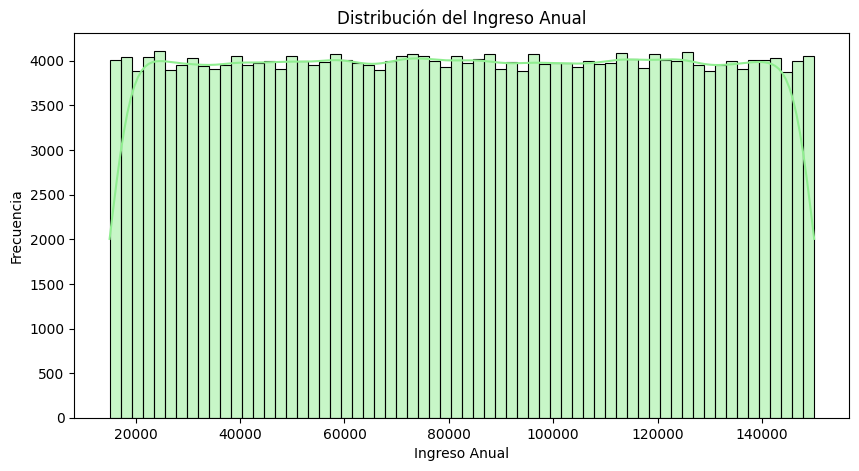

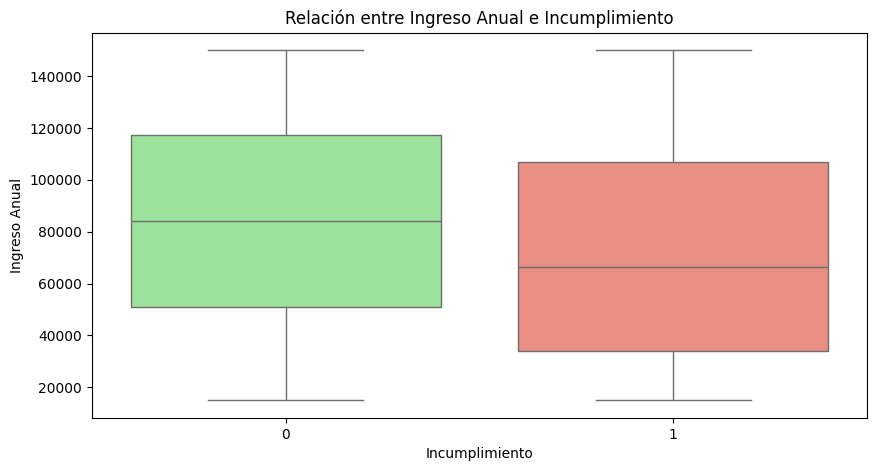

In [19]:
# Income (Ingreso Anual)

# Histograma de la variable 'Income'
plt.figure(figsize=(10, 5))
sns.histplot(df['Income'], kde=True, color='lightgreen')
plt.title('Distribución del Ingreso Anual')
plt.xlabel('Ingreso Anual')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de 'Income' vs 'Default'
plt.figure(figsize=(10, 5))
sns.boxplot(x='Default', y='Income', hue='Default', data=df, palette=['lightgreen', 'salmon'], legend=False)
plt.title('Relación entre Ingreso Anual e Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Ingreso Anual')
plt.show()


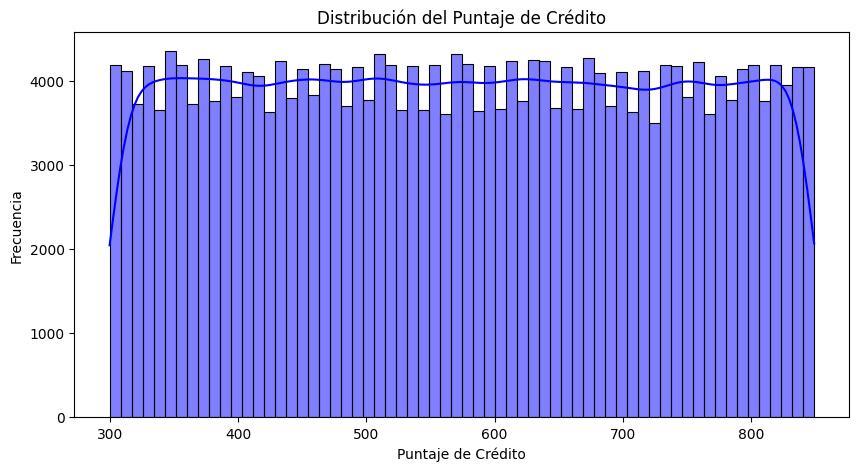

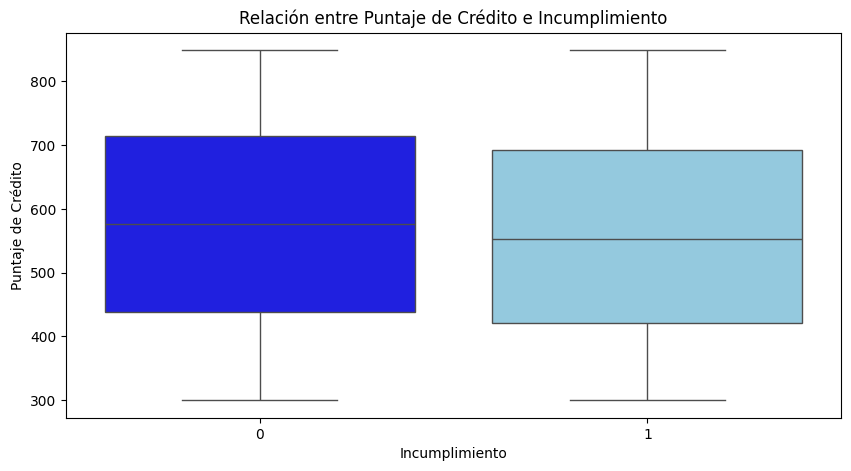

In [26]:
# CreditScore (Puntaje de Crédito)

# Histograma de la variable 'CreditScore'
plt.figure(figsize=(10, 5))
sns.histplot(df['CreditScore'], kde=True, color='blue')
plt.title('Distribución del Puntaje de Crédito')
plt.xlabel('Puntaje de Crédito')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de 'CreditScore' vs 'Default'
plt.figure(figsize=(10, 5))
sns.boxplot(x='Default', y='CreditScore', hue='Default', data=df, palette=['blue', 'skyblue'], legend=False)
plt.title('Relación entre Puntaje de Crédito e Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Puntaje de Crédito')
plt.show()


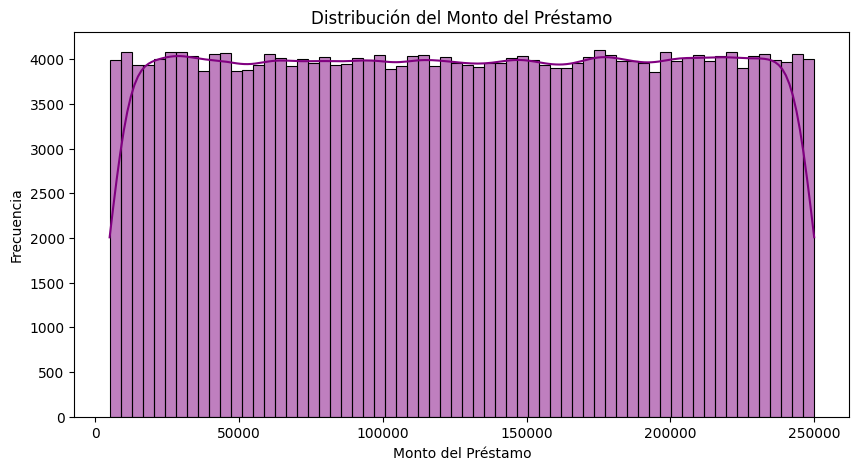

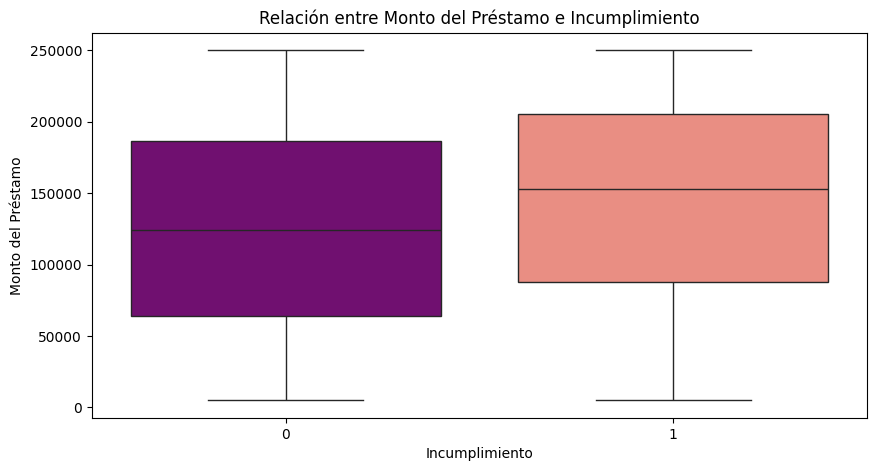

In [28]:
# LoanAmount (Monto del Préstamo)

# Histograma de la variable 'LoanAmount'
plt.figure(figsize=(10, 5))
sns.histplot(df['LoanAmount'], kde=True, color='purple')
plt.title('Distribución del Monto del Préstamo')
plt.xlabel('Monto del Préstamo')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de 'LoanAmount' vs 'Default'
plt.figure(figsize=(10, 5))
sns.boxplot(x='Default', y='LoanAmount', hue='Default', data=df, palette=['purple', 'salmon'], legend=False)
plt.title('Relación entre Monto del Préstamo e Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Monto del Préstamo')
plt.show()


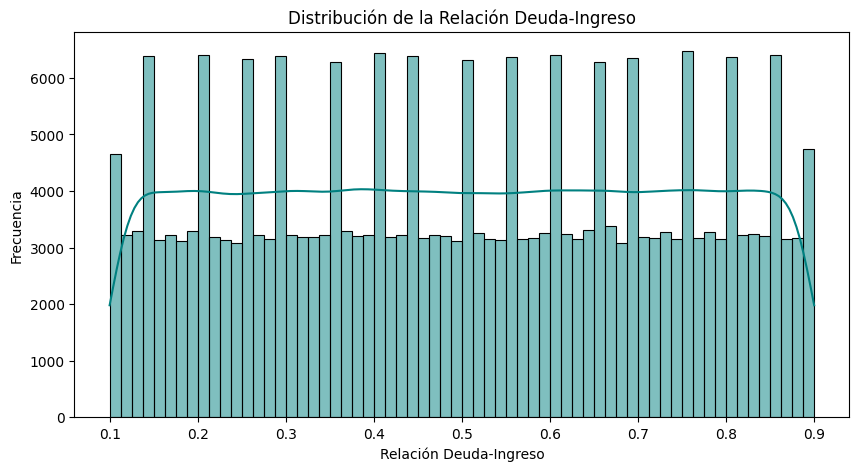

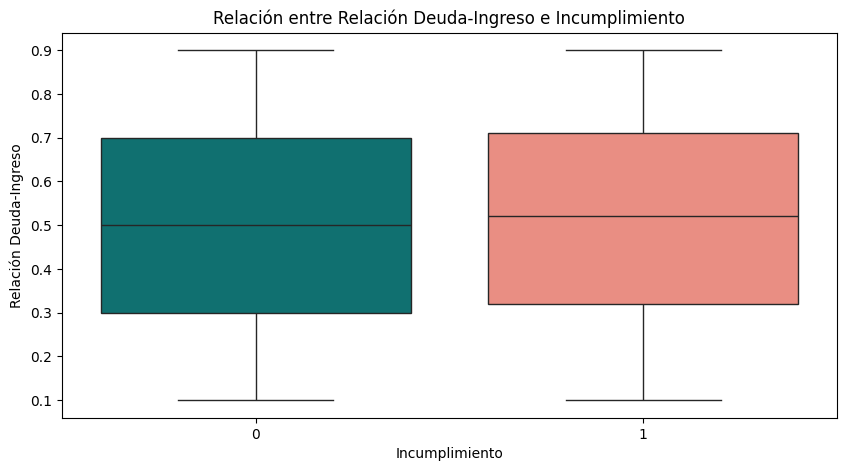

In [31]:
# DTIRatio (Relación Deuda-Ingreso)

# Histograma de la variable 'DTIRatio'
plt.figure(figsize=(10, 5))
sns.histplot(df['DTIRatio'], kde=True, color='teal')
plt.title('Distribución de la Relación Deuda-Ingreso')
plt.xlabel('Relación Deuda-Ingreso')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de 'DTIRatio' vs 'Default'
plt.figure(figsize=(10, 5))
sns.boxplot(x='Default', y='DTIRatio', hue='Default', data=df, palette=['teal', 'salmon'], legend=False)
plt.title('Relación entre Relación Deuda-Ingreso e Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Relación Deuda-Ingreso')
plt.show()

EmploymentType
Part-time        64161
Unemployed       63824
Self-employed    63706
Full-time        63656
Name: count, dtype: int64


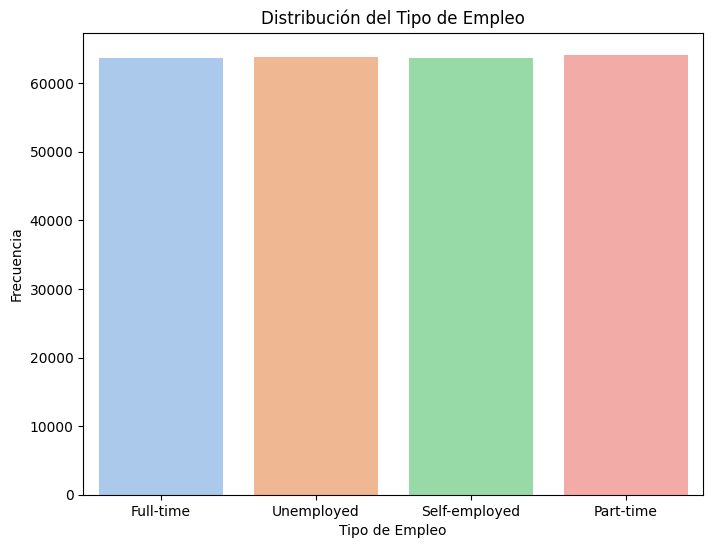

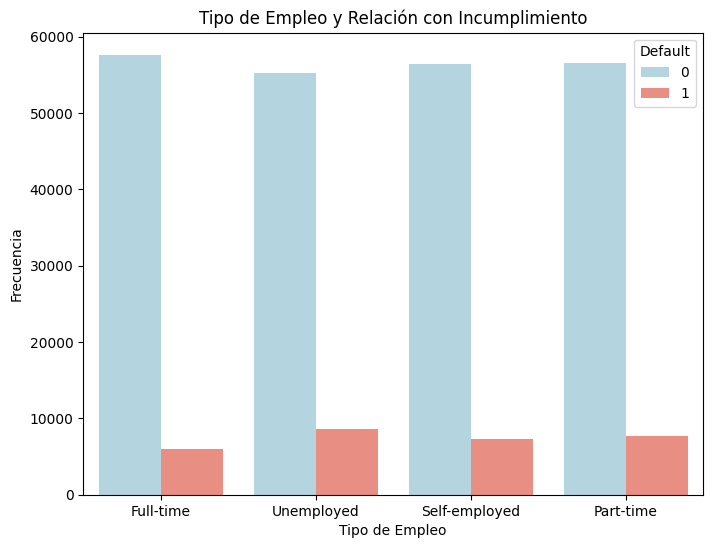

In [45]:
# EmploymentType (Tipo de Empleo)

# Frecuencia de cada tipo de empleo
employment_counts = df['EmploymentType'].value_counts()
print(employment_counts)

# Gráfico de barras de 'EmploymentType'
plt.figure(figsize=(8, 6))
sns.countplot(x='EmploymentType', data=df, hue='EmploymentType', palette='pastel', legend=False)
plt.title('Distribución del Tipo de Empleo')
plt.xlabel('Tipo de Empleo')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras para 'EmploymentType' vs 'Default'
plt.figure(figsize=(8, 6))
sns.countplot(x='EmploymentType', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Tipo de Empleo y Relación con Incumplimiento')
plt.xlabel('Tipo de Empleo')
plt.ylabel('Frecuencia')
plt.show()

HasDependents
Yes    50.026826
No     49.973174
Name: proportion, dtype: float64


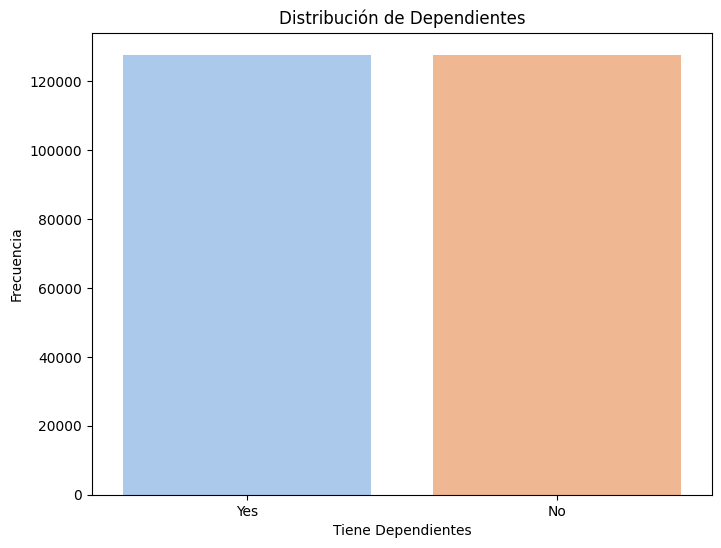

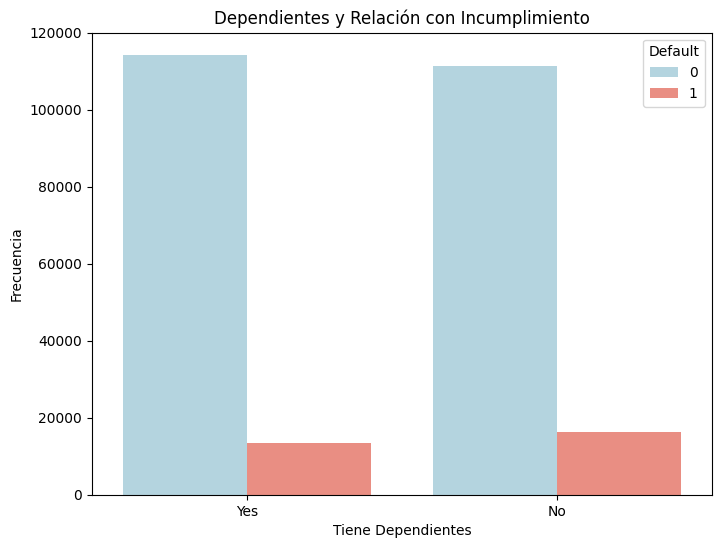

In [48]:
# HasDependents (Tiene Dependientes)

# Distribución de 'HasDependents'
dependents_dist = df['HasDependents'].value_counts(normalize=True) * 100
print(dependents_dist)

# Gráfico de barras de 'HasDependents'
plt.figure(figsize=(8, 6))
sns.countplot(x='HasDependents', data=df, hue='HasDependents', palette='pastel', legend=False)
plt.title('Distribución de Dependientes')
plt.xlabel('Tiene Dependientes')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras para 'HasDependents' vs 'Default'
plt.figure(figsize=(8, 6))
sns.countplot(x='HasDependents', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Dependientes y Relación con Incumplimiento')
plt.xlabel('Tiene Dependientes')
plt.ylabel('Frecuencia')
plt.show()

LoanPurpose (Propósito del Préstamo)

LoanPurpose
Business     51298
Home         51286
Education    51005
Other        50914
Auto         50844
Name: count, dtype: int64


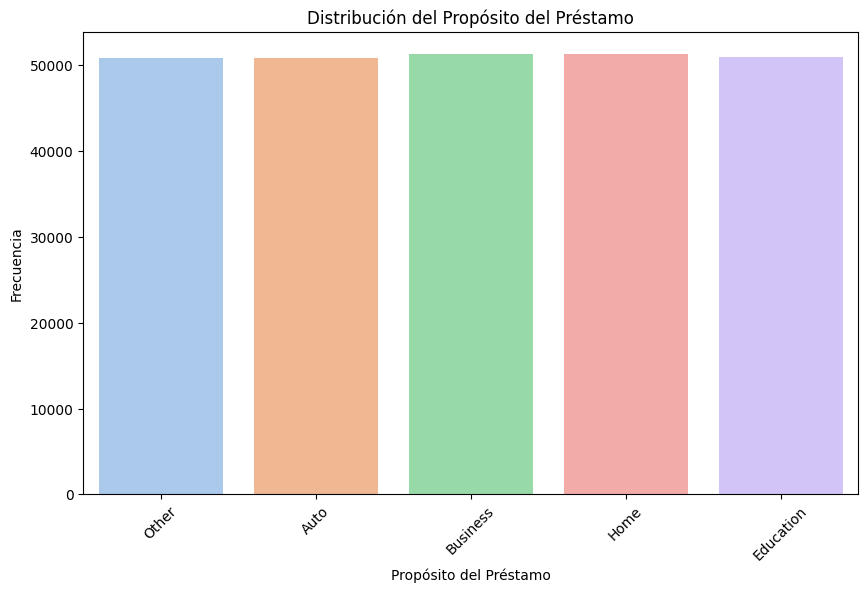

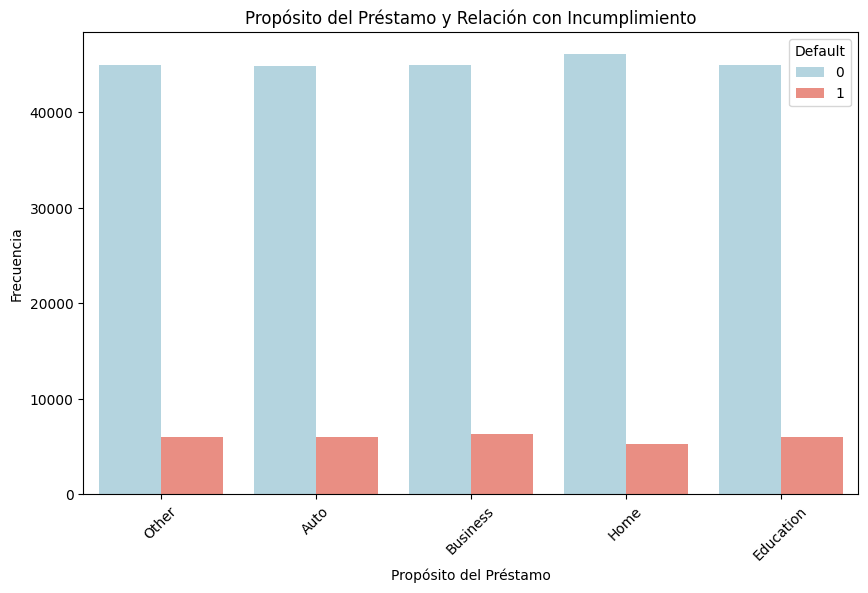

In [51]:
# Frecuencia de cada propósito del préstamo
purpose_counts = df['LoanPurpose'].value_counts()
print(purpose_counts)

# Gráfico de barras de 'LoanPurpose'
plt.figure(figsize=(10, 6))
sns.countplot(x='LoanPurpose', data=df, hue='LoanPurpose', palette='pastel', legend=False)
plt.title('Distribución del Propósito del Préstamo')
plt.xlabel('Propósito del Préstamo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para 'LoanPurpose' vs 'Default'
plt.figure(figsize=(10, 6))
sns.countplot(x='LoanPurpose', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Propósito del Préstamo y Relación con Incumplimiento')
plt.xlabel('Propósito del Préstamo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

MaritalStatus (Estado Civil)

MaritalStatus
Married     85302
Divorced    85033
Single      85012
Name: count, dtype: int64


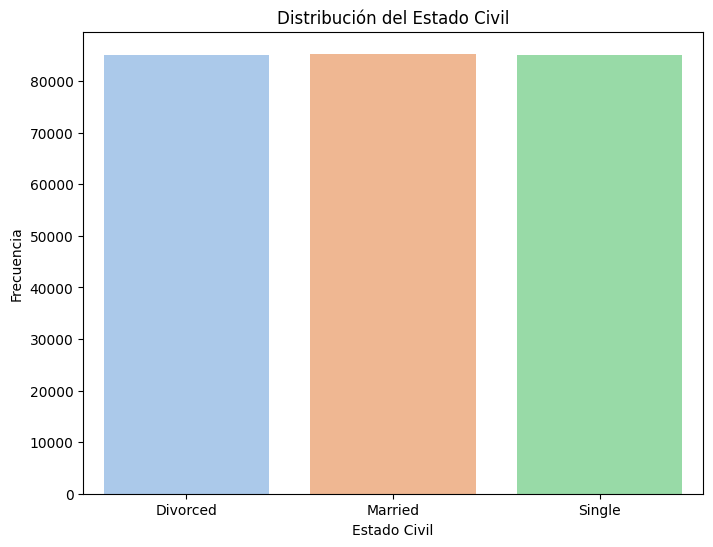

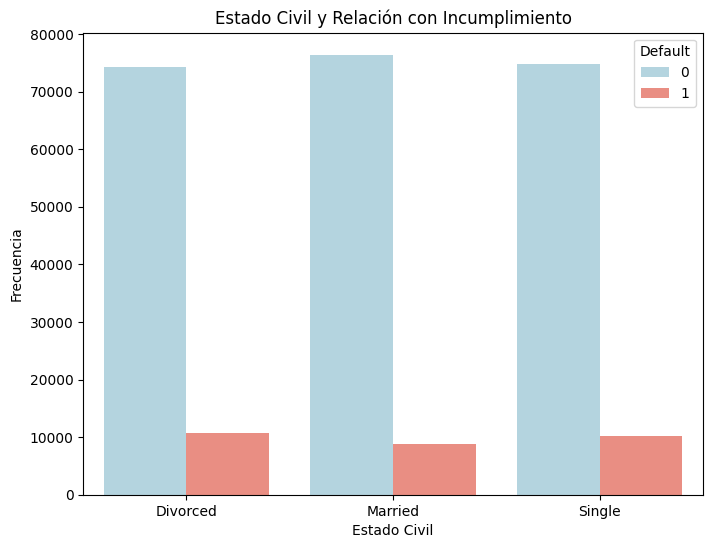

In [54]:
# Frecuencia de cada estado civil
marital_status_counts = df['MaritalStatus'].value_counts()
print(marital_status_counts)

# Gráfico de barras de 'MaritalStatus'
plt.figure(figsize=(8, 6))
sns.countplot(x='MaritalStatus', data=df, hue='MaritalStatus', palette='pastel', legend=False)
plt.title('Distribución del Estado Civil')
plt.xlabel('Estado Civil')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras para 'MaritalStatus' vs 'Default'
plt.figure(figsize=(8, 6))
sns.countplot(x='MaritalStatus', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Estado Civil y Relación con Incumplimiento')
plt.xlabel('Estado Civil')
plt.ylabel('Frecuencia')
plt.show()

# 3. Detección de valores nulos y extremos

In [5]:
# Revisar valores nulos
print(df.isnull().sum())

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


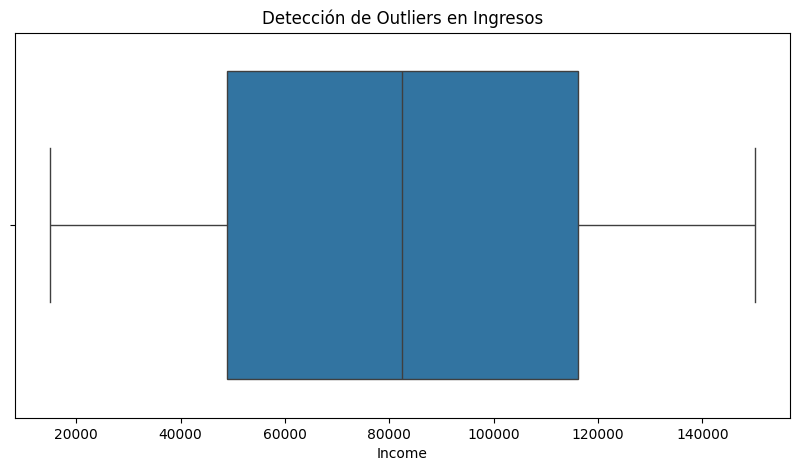

In [6]:
# Identificación de outliers en 'Income'
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Income'])
plt.title('Detección de Outliers en Ingresos')
plt.show()

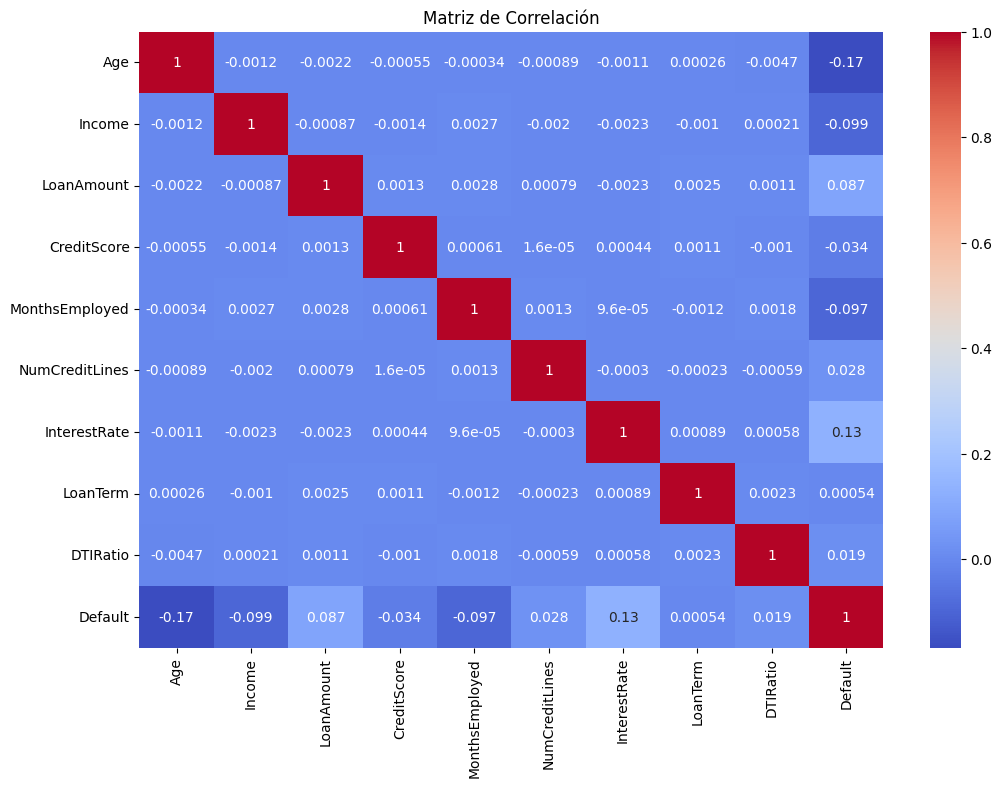

In [10]:
# Filtrar solo las columnas numéricas
numeric_df = df.select_dtypes(include='number')

# Matriz de correlación
corr_matrix = numeric_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


In [33]:
# Estadísticas descriptivas de 'Income'
print(df['Income'].describe())

# Estadísticas descriptivas de 'CreditScore'
print(df['CreditScore'].describe())


count    255347.000000
mean      82499.304597
std       38963.013729
min       15000.000000
25%       48825.500000
50%       82466.000000
75%      116219.000000
max      149999.000000
Name: Income, dtype: float64
count    255347.000000
mean        574.264346
std         158.903867
min         300.000000
25%         437.000000
50%         574.000000
75%         712.000000
max         849.000000
Name: CreditScore, dtype: float64
